In [1]:
import pyam
import pandas as pd
import numpy as np

import dotenv
import os
from pathlib import Path

# Testing
import numpy.testing as npt

<IPython.core.display.Javascript object>

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
dotenv.load_dotenv()

True

<IPython.core.display.Javascript object>

Step 1: Read in the Gidden and Gasser et al. dataset

In [4]:
df = pyam.IamDataFrame(
    Path(
        os.environ['GIDDEN_DATA']
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file /Users/gauravganti/Documents/databases/gidden_et_al_2022_ar6_reanalysis_data.xlsx
pyam.core - INFO: Reading meta indicators


<IPython.core.display.Javascript object>

Step 2: Load the Gidden and Gasser et al. metadata file

NOTE: This is redundant since they updated the data to a single excel file.

Step 3: Filter out for the C1 - C3 scenarios using the 'Category' column in the metadata.

In [5]:
df_1p5 = (
    df
    .filter(
        Category=['C1','C2','C3']
    )
)

<IPython.core.display.Javascript object>

Step 3.1 (Check): Make sure that we have the correct categories.

In [6]:
npt.assert_equal(
    np.array(sorted(df_1p5.meta.Category.unique())),
    np.array(['C1', 'C2', 'C3'], dtype=object)
)

<IPython.core.display.Javascript object>

In [7]:
df_1p5.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only']

<IPython.core.display.Javascript object>

Step 4: Read in the AR6 R5 scenario data. We will use this to compile the novel CDR information at the R5 level, which is missing in the Gidden and Gasser et al. dataset.

In [8]:
r5_data = pd.read_csv(
    os.environ['AR6_R5_DATA'],
    index_col=[0,1]
)

<IPython.core.display.Javascript object>

Step 5: Filter out for the scenarios present in the Gidden, Gasser, et al. data.

In [9]:
r5_data_selected = r5_data.loc[
    df_1p5.meta.index, 
    :
]

<IPython.core.display.Javascript object>

Step 6: Filter out for the necessary variables and then cast this to a pyam dataframe. The necessary variables are:
1. BECCS: Carbon Sequestration|CCS|Biomass
2. DACCS: Carbon Sequestration|Direct Air Capture
3. EW: Carbon Sequestration|Enhanced Weathering

In [10]:
r5_data_selected_variables = r5_data_selected[
    r5_data_selected['Variable'].isin(
        [
            'Carbon Sequestration|CCS|Biomass',
            'Carbon Sequestration|Direct Air Capture',
            'Carbon Sequestration|Enhanced Weathering'
        ]
    ) 
].reset_index()

<IPython.core.display.Javascript object>

In [11]:
r5_pyam = pyam.IamDataFrame(r5_data_selected_variables)

<IPython.core.display.Javascript object>

In [12]:
r5_pyam.unit_mapping

{'Carbon Sequestration|CCS|Biomass': 'Mt CO2/yr',
 'Carbon Sequestration|Direct Air Capture': 'Mt CO2/yr',
 'Carbon Sequestration|Enhanced Weathering': 'Mt CO2/yr'}

<IPython.core.display.Javascript object>

Step 7: Compute an aggregate novel (i.e., non-land) removal variable.

In [13]:
r5_pyam_novel = r5_pyam.aggregate(
    variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
    components=[
        'Carbon Sequestration|CCS|Biomass',
        'Carbon Sequestration|Direct Air Capture',
        'Carbon Sequestration|Enhanced Weathering'   
    ]
)

<IPython.core.display.Javascript object>

/Users/gauravganti/opt/anaconda3/envs/ar6_cdr_assessment/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
pyam.plotting - INFO: >=13 labels, not applying legend


<Axes: title={'center': 'variable: AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land'}, xlabel='Year', ylabel='Mt CO2/yr'>

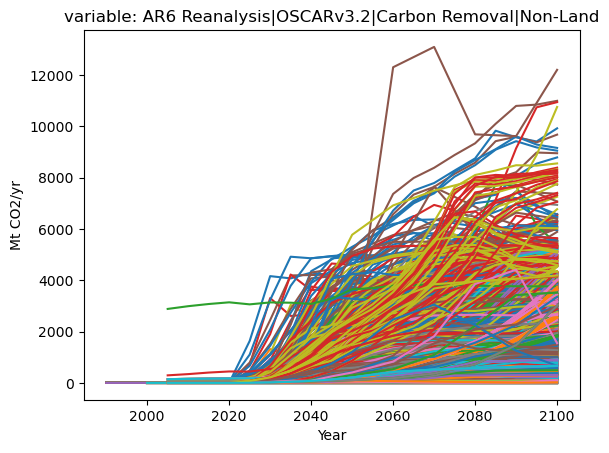

<IPython.core.display.Javascript object>

In [14]:
r5_pyam_novel.plot()

Step 8: Check what is going wrong in one scenarios (high novel removals between 2000 and 2020). We will not exclude this scenario, but will note that it has anomalously high near-term removals in the methods section.

In [15]:
r5_pyam_novel.validate(
    criteria={
        'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land': {
            'up': 200,
            'year':2015
            }
    }
)

pyam.core - INFO: 2 of 33010 data points do not satisfy the criteria


,model,scenario,region,variable,unit,year,value
0,REMIND-MAgPIE 2.1-4.3,DeepElec_SSP2_ HighRE_Budg900,R5MAF,AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land,Mt CO2/yr,2015,3076.3841
1,REMIND-MAgPIE 2.1-4.3,DeepElec_SSP2_ HighRE_Budg900,R5OECD90+EU,AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land,Mt CO2/yr,2015,402.7431


<IPython.core.display.Javascript object>

/Users/gauravganti/opt/anaconda3/envs/ar6_cdr_assessment/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


<Axes: title={'center': 'model: REMIND-MAgPIE 2.1-4.3 - scenario: DeepElec_SSP2_ HighRE_Budg900 - region: R5MAF'}, xlabel='Year', ylabel='Mt CO2/yr'>

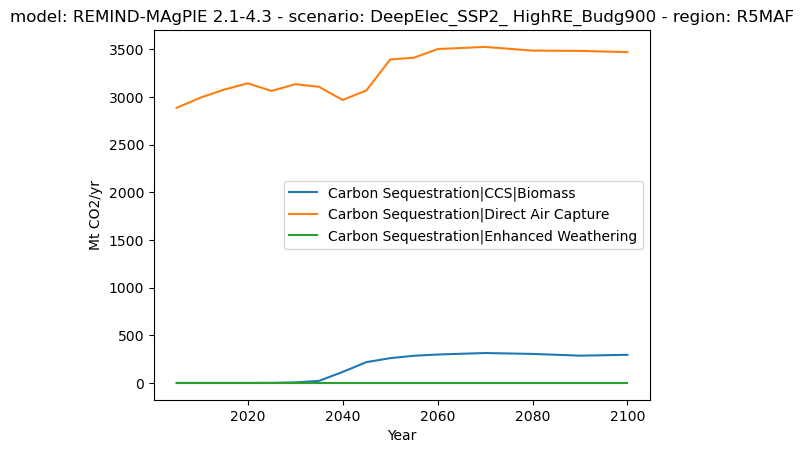

<IPython.core.display.Javascript object>

In [16]:
r5_pyam.filter(
    region='R5MAF',
    scenario='DeepElec_SSP2_ HighRE_Budg900',
    model='REMIND-MAgPIE 2.1-4.3'
).plot(color='variable')

Step 9: Interpolate between 2020 and 2100.

In [17]:
r5_pyam_novel.interpolate(
    time=range(2020, 2101),
    inplace=True
)

<IPython.core.display.Javascript object>

Step 10: Concatenate with the filtered Gidden and Gasser dataset.

In [18]:
df_1p5 = pyam.concat(
    [
        df_1p5, 
        r5_pyam_novel
    ]
)

<IPython.core.display.Javascript object>

Step 11: Calculate the total carbon removal only considering the direct component on land.

In [19]:
df_1p5.aggregate(
    variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
    components=[
        'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
        'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land'
    ],
    append=True
)

<IPython.core.display.Javascript object>

Step 12: Calculate the gross emissions in each scenario. Then, make sure that it is always positive globally.

In [20]:
df_1p5.aggregate(
    variable='AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
    components=[
        'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
        'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total' # Checked with Matt
    ],
    append=True
)

<IPython.core.display.Javascript object>

/Users/gauravganti/opt/anaconda3/envs/ar6_cdr_assessment/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
pyam.plotting - INFO: >=13 labels, not applying legend


<Axes: title={'center': 'variable: AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross'}, xlabel='Year', ylabel='Mt CO2/yr'>

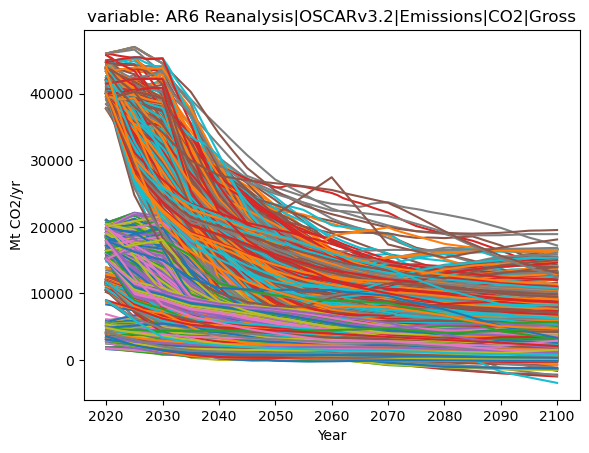

<IPython.core.display.Javascript object>

In [21]:
df_1p5.filter(
    year=range(2020, 2101),
    variable='*Emissions|CO2|Gross'
).plot()

In [22]:
valid_gross = (
    df_1p5
    .filter(region='World')
    .validate(
        criteria={
            'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross': {
                'lo': 0, # Using this error margin 
                #'year': 2100,
            }
        }
    )
    .set_index(['model', 'scenario'])
)

pyam.core - INFO: 68 of 608161 data points do not satisfy the criteria


<IPython.core.display.Javascript object>

In [23]:
valid_gross.index.unique()

MultiIndex([('COFFEE 1.1',                'CO_Bridge'),
            ('COFFEE 1.1',        'EN_INDCi2030_400f'),
            ('COFFEE 1.1',        'EN_INDCi2030_500f'),
            ('COFFEE 1.1',          'EN_NPi2020_400f'),
            ('COFFEE 1.1', 'EN_NPi2020_400f_lowBECCS'),
            ('COFFEE 1.1',          'EN_NPi2020_500f')],
           names=['model', 'scenario'])

<IPython.core.display.Javascript object>

In [24]:
df_1p5.set_meta(
    name='exclude',
    meta=True,
    index=valid_gross.index.unique()
)

<IPython.core.display.Javascript object>

In [25]:
df_1p5.filter(exclude=True)

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : COFFEE 1.1 (1)
 * scenario : CO_Bridge, EN_INDCi2030_400f, EN_INDCi2030_500f, ... EN_NPi2020_500f (6)
Timeseries data coordinates:
   region   : R5ASIA, R5LAM, R5MAF, R5OECD90+EU, R5REF, World (6)
   variable : AR6 Reanalysis|OSCARv3.2|Carbon Removal, ... (14)
   unit     : Mt CO2-equiv/yr, Mt CO2/yr (2)
   year     : 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, ... 2100 (111)
Meta indicators:
   Category (object) C3, C2 (2)
   Category_name (object) C3: limit warming to 2°C (>67%), ... (2)
   Category_subset (object) C3, C2, C3a_Immediate_Action (3)
   Category_Vetting_historical (object) C3, C2 (2)
   IMP_marker (object) nan, Neg (2)
   ...

<IPython.core.display.Javascript object>

In [26]:
(
    valid_gross['value']
    .describe()
    .round(0)
)

count      68.0
mean    -1187.0
std       864.0
min     -3449.0
25%     -1719.0
50%      -997.0
75%      -508.0
max       -34.0
Name: value, dtype: float64

<IPython.core.display.Javascript object>

In [27]:
df_1p5.filter(
    exclude=False,
    inplace=True
)

<IPython.core.display.Javascript object>

Step 13: Convert all units to Gt of the emissions species.

In [28]:
df_1p5.unit_mapping

{'AR6 Reanalysis|OSCARv3.2|Carbon Removal': 'Mt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land': 'Mt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct': 'Mt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect': 'Mt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land': 'Mt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total': 'Mt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2': 'Mt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU': 'Mt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct': 'Mt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect': 'Mt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only': 'Mt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross': 'Mt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases': 'Mt CO2-equiv/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only': 'Mt CO2-equiv/yr'}

<IPython.core.display.Javascript object>

In [29]:
df_1p5.convert_unit(
    current='Mt CO2/yr',
    to='Gt CO2/yr',
    inplace=True
)

<IPython.core.display.Javascript object>

In [30]:
df_1p5.convert_unit(
    current='Mt CO2-equiv/yr',
    to='Gt CO2-equiv/yr',
    inplace=True
)

<IPython.core.display.Javascript object>

In [31]:
df_1p5.unit_mapping

{'AR6 Reanalysis|OSCARv3.2|Carbon Removal': 'Gt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land': 'Gt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct': 'Gt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect': 'Gt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land': 'Gt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total': 'Gt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2': 'Gt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU': 'Gt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct': 'Gt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect': 'Gt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only': 'Gt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross': 'Gt CO2/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases': 'Gt CO2-equiv/yr',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only': 'Gt CO2-equiv/yr'}

<IPython.core.display.Javascript object>

Step 14: Pull out the year of net zero CO2 emissions from the data. We fill in nan scenarios with 2100.

In [32]:
column_net_zero = 'Year of netzero CO2 emissions (Harm-Infilled) table'

<IPython.core.display.Javascript object>

In [33]:
(
    df_1p5
    .meta
    .loc[:, column_net_zero]
    .fillna(2100, inplace=True)
)

<IPython.core.display.Javascript object>

Step 15: We will need to calculate the cumulative total removals between net zero CO2 and 2100.

In [34]:
cdr_total = (
    df_1p5
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
        region='World'
    )
    .timeseries()
)

<IPython.core.display.Javascript object>

In [35]:
cdr_cumulative_net_zero_2100 = cdr_total.apply(
    lambda x: pyam.cumulative(
        x,
        first_year=df_1p5.meta.loc[x.name[0:2], column_net_zero],
        last_year=2100
    ),
    axis=1
)

<IPython.core.display.Javascript object>

In [36]:
df_1p5.set_meta(
    meta=cdr_cumulative_net_zero_2100,
    name='cumulative_cdr_netzero_2100'
)

<IPython.core.display.Javascript object>

Step 16: Set the gross emissions and total CDR at net zero across all the pathways

In [37]:
cdr_net_zero = cdr_total.apply(
    lambda x: pyam.cumulative(
        x,
        first_year=df_1p5.meta.loc[x.name[0:2], column_net_zero],
        last_year=df_1p5.meta.loc[x.name[0:2], column_net_zero]
    ),
    axis=1
)

<IPython.core.display.Javascript object>

Step 16.1: Just to be sure, let us check that pulling out the values from the timeseries returns the same value.

In [38]:
cdr_net_zero_alt = (
    cdr_total
    .apply(
        lambda x: x[df_1p5.meta.loc[x.name[0:2], column_net_zero]],
        axis=1
    )
)

<IPython.core.display.Javascript object>

In [39]:
cdr_net_zero_alt.equals(cdr_net_zero)

True

<IPython.core.display.Javascript object>

Yeah, that works, now let us set it to the metadata.

In [40]:
df_1p5.set_meta(
    meta=cdr_net_zero,
    name='cdr_net_zero'
)

<IPython.core.display.Javascript object>

In [41]:
gross_total = (
    df_1p5
    .filter(
        variable='*Gross',
        region='World'
    )
    .timeseries()
)

<IPython.core.display.Javascript object>

In [42]:
gross_net_zero = gross_total.apply(
    lambda x: pyam.cumulative(
        x,
        first_year=df_1p5.meta.loc[x.name[0:2], column_net_zero],
        last_year=df_1p5.meta.loc[x.name[0:2], column_net_zero]
    ),
    axis=1
)

<IPython.core.display.Javascript object>

In [43]:
df_1p5.set_meta(
    meta=gross_net_zero,
    name='gross_net_zero'
)

<IPython.core.display.Javascript object>

In [44]:
gross_cumulative = gross_total.apply(
    lambda x: pyam.cumulative(
        x,
        first_year=df_1p5.meta.loc[x.name[0:2], column_net_zero],
        last_year=2100
    ),
    axis=1
)

<IPython.core.display.Javascript object>

In [45]:
gross_cumulative_2020 = gross_total.apply(
    lambda x: pyam.cumulative(
        x,
        first_year=2020,
        last_year=df_1p5.meta.loc[x.name[0:2], column_net_zero]
    ),
    axis=1
)

<IPython.core.display.Javascript object>

In [46]:
df_1p5.set_meta(
    meta=gross_cumulative,
    name='cumulative_gross_netzero_2100'
)

<IPython.core.display.Javascript object>

In [47]:
df_1p5.set_meta(
    meta=gross_cumulative_2020,
    name='cumulative_gross_2020_netzero'
)

<IPython.core.display.Javascript object>

Step 17: For the land- and novel CDR, calculate the cumulative removal between 2020 and net zero CO2.

In [48]:
to_crunch = [
    ('land_cdr_2020_netzero', 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct'),
    ('novel_cdr_2020_netzero', 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land')
]

<IPython.core.display.Javascript object>

In [49]:
for col, var in to_crunch:
    data_ts = (
        df_1p5
        .filter(
            variable=var,
            region='World'
        )
        .timeseries()
    )
    df_1p5.set_meta(
        data_ts.apply(
            lambda x: pyam.cumulative(
                x,
                first_year=2020,
                last_year=df_1p5.meta.loc[x.name[0:2], column_net_zero]
            ),
            axis=1
        ),
        name=col
    )

<IPython.core.display.Javascript object>

In [50]:
to_crunch = [
    ('land_cdr_netzero_2100', 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct'),
    ('novel_cdr_netzero_2100', 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land')
]

<IPython.core.display.Javascript object>

In [51]:
for col, var in to_crunch:
    data_ts = (
        df_1p5
        .filter(
            variable=var,
            region='World'
        )
        .timeseries()
    )
    df_1p5.set_meta(
        data_ts.apply(
            lambda x: pyam.cumulative(
                x,
                first_year=df_1p5.meta.loc[x.name[0:2], column_net_zero],
                last_year=2100
            ),
            axis=1
        ),
        name=col
    )

<IPython.core.display.Javascript object>

Step 18: Pull out the non-CO2 estimates aggregated using GWP100.

In [52]:
df_1p5.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only']

<IPython.core.display.Javascript object>

In [53]:
df_1p5.subtract(
    a='AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
    b='AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
    ignore_units='Gt CO2-equiv/yr',
    name='AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only',
    append=True
)

<IPython.core.display.Javascript object>

In [54]:
final_data = df_1p5

<IPython.core.display.Javascript object>

Step 16: Save this data out for further analysis.

In [55]:
final_data.to_excel(
    Path(
        '../data/101_data.xlsx'
    )
)

<IPython.core.display.Javascript object>